In [4]:
import pandas as pd
import numpy as np

import os
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split

import keras_metrics

import cv2

In [8]:
input_size = (32, 32)

def preprocess_dataset(image):
    image = cv2.resize(image, input_size)
    return image

In [6]:
# walk the directory containing alpaca/not alpaca and read them in. 
# might be different shapes
# all have 3 channels
alpaca_images = []
for dirname, _, filenames in os.walk('dataset/alpaca'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            imnp = preprocess_dataset(imnp)
            alpaca_images.append(imnp)

not_alpaca_images = []
for dirname, _, filenames in os.walk('dataset/not alpaca'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            imnp = preprocess_dataset(imnp)
            not_alpaca_images.append(imnp)

This is 1 channel, so we omit it (683, 1024) 4b9ef3ce2685ee32.jpg
This is 1 channel, so we omit it (914, 1024) 5a71db307230880e.jpg


## Preprocessing data

In [9]:
# scale image from [0, 255] to [0, 1]
alpaca_images = np.asarray(alpaca_images) / 255.
not_alpaca_images = np.asarray(not_alpaca_images) / 255.

# loading data
X = np.concatenate((alpaca_images, not_alpaca_images), axis=0) # X.shape=(325, 300, 300, 3)

# 0 -> alpaca_images, 1-> not_alpaca_images
y = np.concatenate((np.zeros(alpaca_images.shape[0], dtype=int),  # y.shape=(325,)
                    np.ones(not_alpaca_images.shape[0], dtype=int)), 
                   axis=0)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(292, 32, 32, 3) (292,)
(33, 32, 32, 3) (33,)


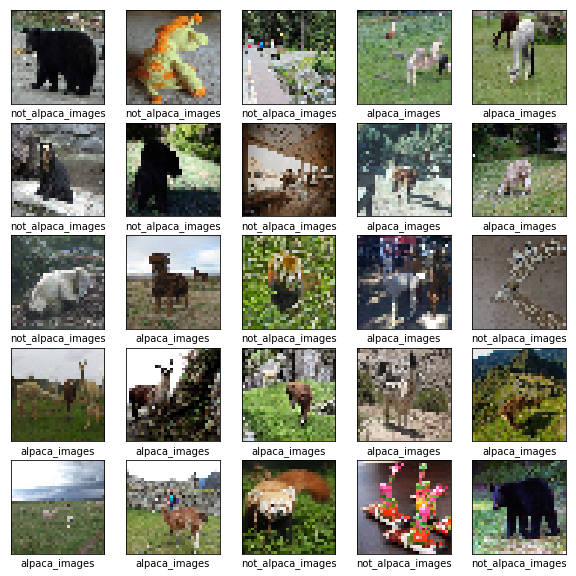

In [11]:
class_names = ['alpaca_images', 'not_alpaca_images']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[int(y_train[i])])
plt.show()

## 2D CNN Model 

In [12]:
cnn2d = keras.Sequential((
    # input layer
    keras.Input(shape=(32, 32, 3)),
    # convolutional layer1 + ActivationLayer1
    layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # PoolingLayer1
    layers.AveragePooling2D(pool_size=(2, 2)),
    
    # convolutional layer2 + ActivationLayer2
    layers.Conv2D(filters=12, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # PoolingLayer2
    layers.AveragePooling2D(pool_size=(2, 2)),
    
    # convolutional layer3 + ActivationLayer33
    layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # Dense layer1
    layers.Flatten(name='flatten'),
    layers.Dense(12),
    
    # output layer
    layers.Dense(1, activation='softmax'),
))

In [10]:
cnn2d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 12)        1740      
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 12)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           872       
                                                                 
 flatten (Flatten)           (None, 128)               0

## Train 2D CNN Model

In [11]:
batch_size = 128
epochs = 3

cnn2d.compile(loss="mean_squared_logarithmic_error", 
              optimizer="adam",
              metrics=[
                       #"accuracy", 
                       tf.keras.metrics.Accuracy(),
                       tf.keras.metrics.Precision(thresholds=0.5),
                       tf.keras.metrics.Recall(thresholds=0.5)
                      ])


cnn2d.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

cnn2d.save("keras_2dcnn.saved_model")

Epoch 1/3


2023-03-22 16:34:58.499320: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-22 16:34:58.800067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 193ms/step - loss: 0.2164 - accuracy: 0.5496 - precision: 0.5496 - recall: 1.0000 - val_loss: 0.1762 - val_accuracy: 0.6333 - val_precision: 0.6333 - val_recall: 1.0000
Epoch 2/3
3/3 [==============================] - 0s 24ms/step - loss: 0.2164 - accuracy: 0.5496 - precision: 0.5496 - recall: 1.0000 - val_loss: 0.1762 - val_accuracy: 0.6333 - val_precision: 0.6333 - val_recall: 1.0000
Epoch 3/3
1/3 [=========>....................] - ETA: 0s - loss: 0.2215 - accuracy: 0.5391 - precision: 0.5391 - recall: 1.0000

2023-03-22 16:34:59.347435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 24ms/step - loss: 0.2164 - accuracy: 0.5496 - precision: 0.5496 - recall: 1.0000 - val_loss: 0.1762 - val_accuracy: 0.6333 - val_precision: 0.6333 - val_recall: 1.0000


INFO:tensorflow:Assets written to: keras_2dcnn.saved_model/assets


INFO:tensorflow:Assets written to: keras_2dcnn.saved_model/assets


## Evaluate the 2D CNN

In [12]:
cnn2d.evaluate(
    x=X_test,
    y=y_test)

2/2 [==============================] - 0s 73ms/step - loss: 0.1893 - accuracy: 0.6061 - precision: 0.6061 - recall: 1.0000


[0.1892692744731903, 0.6060606241226196, 0.6060606241226196, 1.0]

# Proposed approach

In [13]:
import torch 
import torch.nn as nn

In [16]:
featureMaps = []
for n in range(3): ## the channel of input
    weightMatrix = torch.tensor(np.random.rand(3, 3, 16)) ## (h_input, w_input, filter size)
    featureMaps.append(weightMatrix)
torch.stack(featureMaps, dim=0).shape

torch.Size([3, 3, 3, 16])

In [39]:
class ProposedLayer(nn.Module):
    
    def __init__(self, num_filters, rf=3, stride=1):
        super().__init__()
        self.rf = rf
        self.num_filters = num_filters
        self.stride = stride
        
    def __len__(self, x):
        return len(x)
      
    def forward(self, X):
        
        self.batch = len(X[:,0])
        self.height = len([1] * X.shape[1])
        self.width = len([1] * X.shape[2])
        self.channel = len([1] * X.shape[3])
        
        self.featureMaps = []
        
        for n in range(self.num_filters):
            self.weightMatrix = torch.tensor(np.random.rand(self.height, self.width, self.channel))
#             self.weightMatrix = torch.tensor(np.random.rand(self.batch, self.height, self.width, self.channel))
            self.featureMaps.append(self.weightMatrix)
            
        self.featureMaps = torch.stack(self.featureMaps, dim=0)
        print(self.featureMaps.shape)
        output = torch.tensor(np.empty((self.batch, self.height-self.rf+1, self.width-self.rf+1, self.num_filters)))
        
        for row in range(self.height - self.rf + 1):
            for col in range(self.width - self.rf + 1):
                for j,_ in enumerate(self.featureMaps):
#                     print(fm.shape)
                    for i,_ in enumerate(X):
                        receptive_field = self.featureMaps[j, row: row+self.rf, col: col+self.rf, :]
                        x_field = X[i, row: row+self.rf, col: col+self.rf, :]

                        x_field_ = torch.flatten(x_field)
                        receptive_field_ = torch.flatten(receptive_field)
                        output[i, row, col] = np.dot(x_field_, receptive_field_)                                
        
        return output

### Input layer – ProposedLayer1– ActivationLayer1 – PoolingLayer1 – ProposedLayer2 – ActivationLayer2 – PoolingLayer2 – ProposedLayer3 – ActivationLayer3 – FullyConnectedLayer1/DenseLayer1 – OutputLayer/Softmax

In [28]:
class ProposedModel(nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv = nn.Conv2d(1, 128, 3)
        # self.linear = nn.Linear(256, 2)
        
        # Block 1
        self.proposedLayer1 = ProposedLayer(num_filters=16, rf=3, stride=1) # proposed layer 1
        self.relu1 = nn.ReLU() # activation layer 1
        self.pool1 = nn.AvgPool2d(2)
        
        # Block 2
        self.proposedLayer2 = ProposedLayer(num_filters=12, rf=3, stride=1) # proposed layer 1
        self.relu2 = nn.ReLU() # activation layer 1
        self.pool2 = nn.AvgPool2d(2)
        
        # Block 3
        self.proposedLayer3 = ProposedLayer(num_filters=8, rf=3, stride=1) # proposed layer 1
        self.relu3 = nn.ReLU() # activation layer 1
        self.fc = nn.Linear(8, 1)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        
        # Block 1
        x = self.proposedLayer1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Block 2
        x = self.proposedLayer2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Block 3
        x = self.proposedLayer3(x)
        x = self.relu3(x)
        x = self.fc(x)
        x = self.output(x)
        
        return x

In [40]:
torch.manual_seed(0)  #  for repeatable results
p_model = ProposedModel().double()
x = torch.tensor(X_train, dtype=torch.float)
p_model

ProposedModel(
  (proposedLayer1): ProposedLayer()
  (relu1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (proposedLayer2): ProposedLayer()
  (relu2): ReLU()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (proposedLayer3): ProposedLayer()
  (relu3): ReLU()
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (output): Softmax(dim=1)
)

In [41]:
output = p_model(x)

torch.Size([16, 32, 32, 3])
torch.Size([12, 30, 15, 8])
torch.Size([8, 28, 6, 6])


In [42]:
output.shape

torch.Size([292, 26, 4, 1])